In [26]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
import joblib
import matplotlib.pyplot as plt

In [2]:
# Loading the dataset
df = pd.read_csv('crop_yield.csv')
# Dropping state column to adjust for state per state imbalances.
df = df.drop(columns=['State'])
df.head()

,Crop,Crop_Year,Season,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,1739.0,794,2051.4,165500.63,539.09,0.420909


In [3]:
# Defining numerical and categorical features
numerical_features = ['Area', 'Production', 'Annual_Rainfall', 'Fertilizer', 'Pesticide']
categorical_features = ['Crop', 'Season']

In [4]:
# Preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [5]:
# Fit the preprocessor to the training data
preprocessor.fit(df.drop('Yield', axis=1))

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Area', 'Production', 'Annual_Rainfall',
                                  'Fertilizer', 'Pesticide']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Crop', 'Season'])])

In [6]:
# Split the data into training and testing sets
X = df.drop('Yield', axis=1)
y = df['Yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [38]:
# Build the neural network model
model = tf.keras.models.Sequential()
# First hidden layer
model.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape=(preprocessor.transform(X_train).shape[1],)))
# Second hidden layer
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
# Third hidden layer
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
# Output layer
model.add(tf.keras.layers.Dense(units=1, activation='linear'))  # Using 'linear' activation for regression

# Check the structure of the model
model.summary()


# model = Sequential([
#     Dense(128, activation='relu', input_shape=(preprocessor.transform(X_train).shape[1],)),
#     Dense(64, activation='relu'),
#     Dense(32, activation='sigmoid'),
#     Dense(1)
# ])



import keras.backend as K
# Define R-squared metric
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))


model.compile(optimizer='adam',loss=tf.keras.losses.Huber(), metrics=['mae', 'mse', r_squared])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 128)               8576      
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 1)                 33        
                                                                 
Total params: 18,945
Trainable params: 18,945
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Train the model
model.fit(preprocessor.transform(X_train).todense(), y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
493/493 [==============================] - 2s 2ms/step - loss: 70.2842 - mae: 70.6142 - mse: 659039.9375 - r_squared: 0.0884
Epoch 2/50
493/493 [==============================] - 1s 2ms/step - loss: 54.4659 - mae: 54.7749 - mse: 451764.9688 - r_squared: -23.5654
Epoch 3/50
493/493 [==============================] - 1s 2ms/step - loss: 51.1627 - mae: 51.4695 - mse: 402303.3438 - r_squared: -111.5240
Epoch 4/50
493/493 [==============================] - 1s 2ms/step - loss: 46.5765 - mae: 46.8818 - mse: 335073.7812 - r_squared: -51.2459
Epoch 5/50
493/493 [==============================] - 1s 2ms/step - loss: 40.3255 - mae: 40.6398 - mse: 247984.4219 - r_squared: -171.2085
Epoch 6/50
493/493 [==============================] - 1s 2ms/step - loss: 29.6889 - mae: 30.0032 - mse: 139348.6406 - r_squared: -579.6586
Epoch 7/50
493/493 [==============================] - 1s 2ms/step - loss: 24.0229 - mae: 24.3388 - mse: 96727.4688 - r_squared: -244.7148
Epoch 8/50
493/493 [=============

In [42]:
# Evaluate the model using RMSE, MAE, and R-squared score
y_pred = model.predict(preprocessor.transform(X_test)).ravel()
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared score: {r2}")

  1/124 [..............................] - ETA: 1s

124/124 [==============================] - 0s 1ms/step
Root Mean Squared Error: 262.4825271024736
Mean Absolute Error: 17.59803017308399
R-squared score: 0.9140119207099159


In [43]:
# Save the model to a file
joblib.dump(model, 'Neural Network Model.pkl')

['Neural Network Model.pkl']

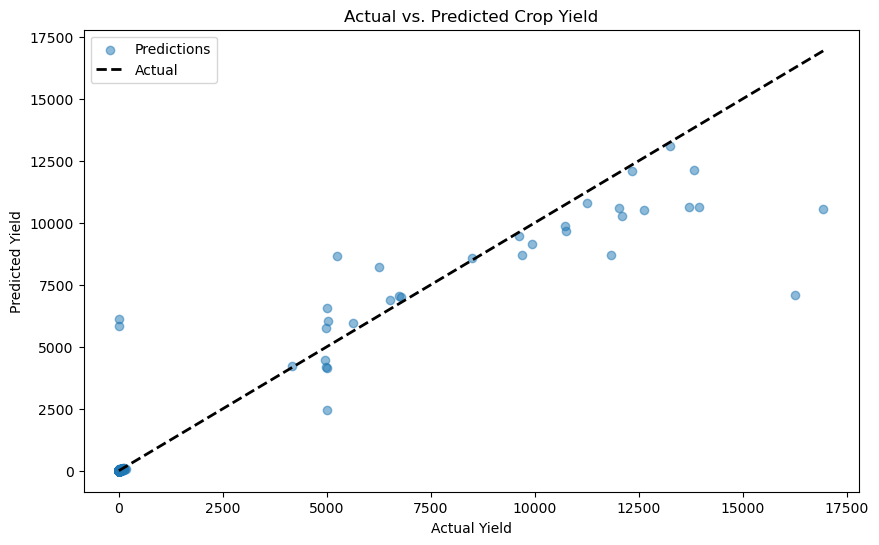

In [44]:
# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.title('Actual vs. Predicted Crop Yield')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Actual')
plt.legend()
plt.show()

In [45]:
# Visualize distribution of prediction errors
errors = y_pred - y_test
mean_error = errors.mean()
median_error = errors.median()

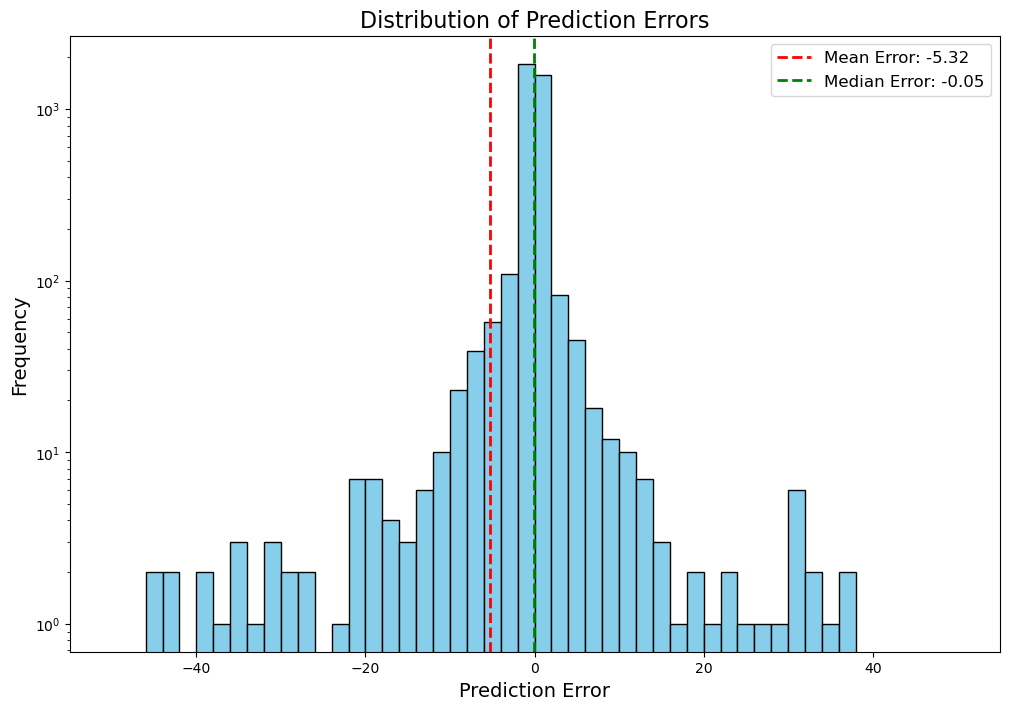

In [46]:
plt.figure(figsize=(12, 8))
hist, bins, _ = plt.hist(errors, bins=50, range=(-50, 50), color='skyblue', edgecolor='black')
plt.title('Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Prediction Error', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yscale('log')
plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f'Mean Error: {mean_error:.2f}')
plt.axvline(median_error, color='green', linestyle='dashed', linewidth=2, label=f'Median Error: {median_error:.2f}')
plt.legend(fontsize=12)
plt.show()

In [47]:
errors_df = pd.DataFrame(errors)
print(errors_df)
print(errors_df.isnull().sum())
error_descriptive_stats = errors_df.describe()
print(error_descriptive_stats)

          Yield
18238 -1.798904
6918   0.447558
4894   1.696016
10960 -0.092553
15615 -0.004277
...         ...
8087   8.131051
14720 -0.001190
9234  -0.085749
19610 -0.170926
1692   0.052749

[3938 rows x 1 columns]
Yield    0
dtype: int64
             Yield
count  3938.000000
mean     -5.317836
std     262.461979
min   -9180.973145
25%      -0.359927
50%      -0.051041
75%       0.240054
max    6126.952148
